<a href="https://colab.research.google.com/github/maurofama99/ann_challenge/blob/main/ANN_challenge1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SetUp

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/ANN/data2

/gdrive/My Drive/ANN/data2


In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# Load the dataset to be used for classification
!unzip training_dataset_homework1.zip

In [7]:
# Dataset folders 
dataset_dir = 'training_data_final'

In [8]:
#get the number of img of each species
import fnmatch

count = [0,0,0,0,0,0,0,0]
labels = ['Species1',       # 0
          'Species2',       # 1
          'Species3',       # 2
          'Species4',       # 3
          'Species5',       # 4
          'Species6',       # 5
          'Species7',       # 6
          'Species8']       # 7

for i in range(len(labels)):
  dir_path = os.path.join(dataset_dir, labels[i])
  count[i] = len(fnmatch.filter(os.listdir(dir_path), '*.*'))
  print('The number of img of', labels[i], 'is: ', count[i])

cumsum = np.cumsum(count)
print('Total amount of img is: ', cumsum[len(cumsum)-1] )

The number of img of Species1 is:  186
The number of img of Species2 is:  532
The number of img of Species3 is:  515
The number of img of Species4 is:  511
The number of img of Species5 is:  531
The number of img of Species6 is:  222
The number of img of Species7 is:  537
The number of img of Species8 is:  508
Total amount of img is:  3542


In [6]:
"Given functions"
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm


def plot_confusionMatrix(test_labels, test_predicted):
  cm = confusion_matrix(test_labels, test_predicted, labels=[0,1,2,3,4,5,6,7])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels)
  disp.plot()
  plt.show()
  return 


In [9]:
def testModel( valid_gen, model):

  # d. Predit test labels
  test_predicted = model.predict(valid_gen)
  test_predicted = np.argmax(test_predicted, axis=-1)
  

  # e. plot confusion matrix
  plot_confusionMatrix(valid_gen.classes, test_predicted)

  # f. display classification results
  print(classification_report(valid_gen.classes, test_predicted, target_names=labels))

In [ ]:
import cv2

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 70
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

def change_color(image):
    image = np.array(image)
    hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    return hsv_image

def preprocessing(image):
    CP1 = 0.3
    CP2 = 0.6
    n = random.random()
    if n<=CP1: 
        return change_color(image)
    elif n>CP1 and n<=CP2:
        return add_noise(image)
    return image

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
data_gen = ImageDataGenerator(rescale=1/255, validation_split=0.2) 

aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        #preprocessing_function=preprocessing,
                                        rescale=1/255,
                                        validation_split=0.2)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = aug_train_data_gen.flow_from_directory(directory=dataset_dir,
                                                           target_size=(96,96),
                                                           color_mode='rgb',
                                                           classes=None, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size=32,
                                                           shuffle=True,
                                                           seed=seed,
                                                           subset="training")

valid_gen = data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=1,
                                               shuffle=False,
                                               seed=seed,
                                               subset="validation")

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [10]:
input_shape = (96, 96, 3)
epochs = 200

##Build Model

In [ ]:
def build_model(input_shape, supernet):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    vgg16_layer = supernet(input_layer) 

    flattening_layer = tfkl.Flatten(name='Flatten')(vgg16_layer)

    layer1 = tfkl.Dense(units=1028, kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout1 = tfkl.Dropout(0.3, seed=seed)(layer1)

    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(dropout1)

    dropout2 = tfkl.Dropout(0.3, seed=seed)(classifier_layer)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

In [ ]:
def build_model2(input_shape, supernet):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    vgg16_layer = supernet(input_layer) 

    flattening_layer = tfkl.Flatten(name='Flatten')(vgg16_layer)

    layer1 = tfkl.Dense(units=1028, kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout1 = tfkl.Dropout(0.3, seed=seed)(layer1)

    classifier_layer = tfkl.Dense(units=1028, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(dropout1)

    dropout2 = tfkl.Dropout(0.3, seed=seed)(classifier_layer)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

In [22]:
def build_model3(input_shape, supernet):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    vgg16_layer = supernet(input_layer) 

    flattening_layer = tfkl.Flatten(name='Flatten')(vgg16_layer)

    layer1 = tfkl.Dense(units=512, kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout1 = tfkl.Dropout(0.2, seed=seed)(layer1)

    classifier_layer = tfkl.Dense(units=256, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(dropout1)

    dropout2 = tfkl.Dropout(0.5, seed=seed)(classifier_layer)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

    # Return the model
    return model

In [ ]:
def build_model4(input_shape, supernet):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    vgg16_layer = supernet(input_layer) 

    flattening_layer = tfkl.Flatten(name='Flatten')(vgg16_layer)

    layer1 = tfkl.Dense(units=1028, kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout1 = tfkl.Dropout(0.2, seed=seed)(layer1)

    classifier_layer = tfkl.Dense(units=1028, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(dropout1)

    dropout2 = tfkl.Dropout(0.5, seed=seed)(classifier_layer)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

    # Return the model
    return model

In [47]:
def create (input_shape, convnet):
  # mark loaded layers as not trainable

  dropout_rate = 0.2
  dropout_rate1 = 0.5

    # Build the model
  input_layer = convnet.layers[0].input
  flat1 = tfkl.Flatten()(convnet.layers[-1].output)
  hidden_layer1 = tfkl.Dense(units=512, activation='relu', name='Hidden1', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(flat1)
  hidden_layer1 = tfkl.Dropout(dropout_rate, seed=seed)(hidden_layer1)
  hidden_layer2 = tfkl.Dense(units=256, activation='relu', name='Hidden2', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(hidden_layer1)
  hidden_layer2 = tfkl.Dropout(dropout_rate1, seed=seed)(hidden_layer2)
  output = tfkl.Dense(units=8, activation='softmax', name='Output', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(hidden_layer2)
    # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output, name='model')

    # Compile the model
  learning_rate = 1e-5
  opt = tfk.optimizers.Adam(learning_rate)
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=opt, metrics='accuracy')

    # Return the model
  return model

In [23]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#VGG16

In [24]:
# Download and plot the VGG16 model
supernet1 = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
for layer in supernet1.layers:
    layer.trainable = True

In [25]:
# Build model and visualize it
model = build_model3(input_shape, supernet1)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 512)               2359808   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='CNN_VGG16_1')

# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 24s 259ms/step - loss: 15.3788 - accuracy: 0.2620 - val_loss: 1.4626 - val_accuracy: 0.4249
Epoch 2/200
89/89 [==============================] - 22s 243ms/step - loss: 13.1265 - accuracy: 0.3713 - val_loss: 1.3630 - val_accuracy: 0.4646
Epoch 3/200
89/89 [==============================] - 22s 243ms/step - loss: 12.3410 - accuracy: 0.4006 - val_loss: 1.3078 - val_accuracy: 0.4844
Epoch 4/200
89/89 [==============================] - 21s 236ms/step - loss: 11.7880 - accuracy: 0.4397 - val_loss: 1.3100 - val_accuracy: 0.4929
Epoch 5/200
89/89 [==============================] - 22s 244ms/step - loss: 11.5282 - accuracy: 0.4503 - val_loss: 1.2735 - val_accuracy: 0.5198
Epoch 6/200
89/89 [==============================] - 22s 247ms/step - loss: 11.3584 - accuracy: 0.4594 - val_loss: 1.2389 - val_accuracy: 0.5113
Epoch 7/200
89/89 [==============================] - 22s 251ms/step - loss: 11.1121 - accuracy: 0.4915 - val_loss: 1.2163 - val_ac

In [ ]:
# Save best epoch model
model.save("savedModels/CNN_VGG16_1")

706/706 [==============================] - 4s 6ms/step


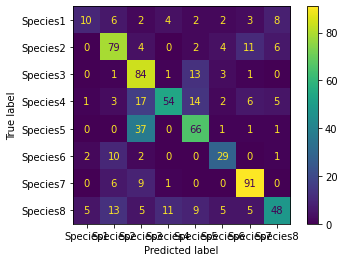

              precision    recall  f1-score   support

    Species1       0.56      0.27      0.36        37
    Species2       0.67      0.75      0.71       106
    Species3       0.53      0.82      0.64       103
    Species4       0.76      0.53      0.62       102
    Species5       0.62      0.62      0.62       106
    Species6       0.63      0.66      0.64        44
    Species7       0.77      0.85      0.81       107
    Species8       0.70      0.48      0.56       101

    accuracy                           0.65       706
   macro avg       0.65      0.62      0.62       706
weighted avg       0.67      0.65      0.65       706



In [ ]:
testModel(valid_gen, model)

In [ ]:
m = tfk.models.load_model("savedModels/CNN_VGG16_1")

In [ ]:
m.get_layer('vgg16').trainable = True

In [ ]:
m.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense_10 (Dense)            (None, 1028)              4738052   
                                                                 
 dropout_16 (Dropout)        (None, 1028)              0         
                                                                 
 Classifier (Dense)          (None, 1028)              1057812   
                                                                 
 dropout_17 (Dropout)        (None, 1028)              0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_VGG16_1_FineTuning')

# Train the model
history = m.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 38s 299ms/step - loss: 8.7123 - accuracy: 0.6217 - val_loss: 0.9865 - val_accuracy: 0.6431
Epoch 2/200
89/89 [==============================] - 22s 244ms/step - loss: 7.9961 - accuracy: 0.6396 - val_loss: 0.9110 - val_accuracy: 0.6629
Epoch 3/200
89/89 [==============================] - 22s 244ms/step - loss: 7.5632 - accuracy: 0.6760 - val_loss: 0.8598 - val_accuracy: 0.6671
Epoch 4/200
89/89 [==============================] - 23s 258ms/step - loss: 7.0565 - accuracy: 0.6760 - val_loss: 0.8249 - val_accuracy: 0.6771
Epoch 5/200
89/89 [==============================] - 22s 249ms/step - loss: 7.2574 - accuracy: 0.6788 - val_loss: 0.8315 - val_accuracy: 0.6870
Epoch 6/200
89/89 [==============================] - 22s 248ms/step - loss: 6.7171 - accuracy: 0.7105 - val_loss: 0.7703 - val_accuracy: 0.6983
Epoch 7/200
89/89 [==============================] - 24s 267ms/step - loss: 6.7690 - accuracy: 0.7052 - val_loss: 0.7905 - val_accuracy:

In [ ]:
# Save best epoch model
m.save("savedModels/CNN_VGG16_1_FineTuning")

706/706 [==============================] - 4s 6ms/step


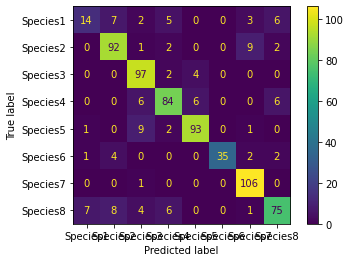

              precision    recall  f1-score   support

    Species1       0.61      0.38      0.47        37
    Species2       0.83      0.87      0.85       106
    Species3       0.81      0.94      0.87       103
    Species4       0.83      0.82      0.83       102
    Species5       0.90      0.88      0.89       106
    Species6       1.00      0.80      0.89        44
    Species7       0.87      0.99      0.93       107
    Species8       0.82      0.74      0.78       101

    accuracy                           0.84       706
   macro avg       0.83      0.80      0.81       706
weighted avg       0.84      0.84      0.84       706



In [ ]:
testModel(valid_gen, m)

build_model2 (1028, 1028) \\
lr Dropout : 0.3 0.3 \\
batch size = 32

706/706 [==============================] - 5s 7ms/step


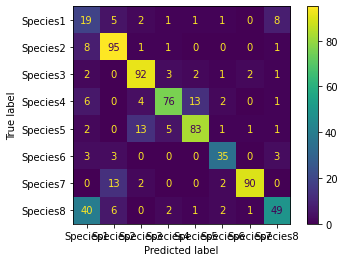

              precision    recall  f1-score   support

    Species1       0.24      0.51      0.32        37
    Species2       0.78      0.90      0.83       106
    Species3       0.81      0.89      0.85       103
    Species4       0.86      0.75      0.80       102
    Species5       0.83      0.78      0.81       106
    Species6       0.80      0.80      0.80        44
    Species7       0.96      0.84      0.90       107
    Species8       0.77      0.49      0.59       101

    accuracy                           0.76       706
   macro avg       0.75      0.74      0.74       706
weighted avg       0.80      0.76      0.77       706



In [ ]:
testModel(valid_gen, m)

build_model3 (516, 228) \\
lr Dropout_ 0.2 0.5 \\
batch size= 32

In [ ]:
m2 = tfk.models.load_model("savedModels/CNN_VGG16_1_FineTuning")

In [ ]:
m2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-6), metrics='accuracy')
m2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense_10 (Dense)            (None, 1028)              4738052   
                                                                 
 dropout_16 (Dropout)        (None, 1028)              0         
                                                                 
 Classifier (Dense)          (None, 1028)              1057812   
                                                                 
 dropout_17 (Dropout)        (None, 1028)              0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_VGG16_2_FineTuning')

# Train the model
history = m2.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 24s 258ms/step - loss: 2.7742 - accuracy: 0.8783 - val_loss: 0.5053 - val_accuracy: 0.8414
Epoch 2/200
89/89 [==============================] - 23s 261ms/step - loss: 2.5939 - accuracy: 0.8843 - val_loss: 0.5198 - val_accuracy: 0.8300
Epoch 3/200
89/89 [==============================] - 23s 262ms/step - loss: 2.4710 - accuracy: 0.8910 - val_loss: 0.5391 - val_accuracy: 0.8215
Epoch 4/200
89/89 [==============================] - 22s 246ms/step - loss: 2.5330 - accuracy: 0.8833 - val_loss: 0.5072 - val_accuracy: 0.8442
Epoch 5/200
89/89 [==============================] - 24s 265ms/step - loss: 2.3236 - accuracy: 0.8988 - val_loss: 0.5218 - val_accuracy: 0.8329
Epoch 6/200
89/89 [==============================] - 22s 249ms/step - loss: 2.4287 - accuracy: 0.8928 - val_loss: 0.5131 - val_accuracy: 0.8371
Epoch 7/200
89/89 [==============================] - 22s 244ms/step - loss: 2.4212 - accuracy: 0.8942 - val_loss: 0.5307 - val_accuracy:

In [ ]:
# Save best epoch model
m2.save("savedModels/CNN_VGG16_2_FineTuning")

706/706 [==============================] - 5s 7ms/step


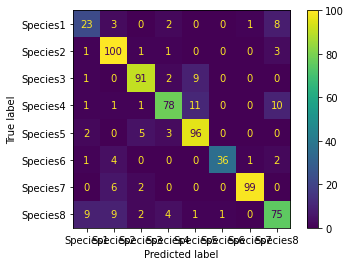

              precision    recall  f1-score   support

    Species1       0.61      0.62      0.61        37
    Species2       0.81      0.94      0.87       106
    Species3       0.89      0.88      0.89       103
    Species4       0.87      0.76      0.81       102
    Species5       0.82      0.91      0.86       106
    Species6       0.97      0.82      0.89        44
    Species7       0.98      0.93      0.95       107
    Species8       0.77      0.74      0.75       101

    accuracy                           0.85       706
   macro avg       0.84      0.83      0.83       706
weighted avg       0.85      0.85      0.85       706



In [ ]:
testModel(valid_gen, m2)

In [ ]:
m3 = tfk.models.load_model("savedModels/CNN_VGG16_2_FineTuning")

In [ ]:
m3.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-7), metrics='accuracy')
m3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense_10 (Dense)            (None, 1028)              4738052   
                                                                 
 dropout_16 (Dropout)        (None, 1028)              0         
                                                                 
 Classifier (Dense)          (None, 1028)              1057812   
                                                                 
 dropout_17 (Dropout)        (None, 1028)              0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_VGG16_3_FineTuning')

# Train the model
history = m3.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 29s 319ms/step - loss: 2.3566 - accuracy: 0.8963 - val_loss: 0.5087 - val_accuracy: 0.8329
Epoch 2/200
89/89 [==============================] - 22s 246ms/step - loss: 2.3369 - accuracy: 0.8984 - val_loss: 0.5109 - val_accuracy: 0.8343
Epoch 3/200
89/89 [==============================] - 22s 248ms/step - loss: 2.3336 - accuracy: 0.8970 - val_loss: 0.5138 - val_accuracy: 0.8314
Epoch 4/200
89/89 [==============================] - 24s 266ms/step - loss: 2.1741 - accuracy: 0.8974 - val_loss: 0.5159 - val_accuracy: 0.8329
Epoch 5/200
89/89 [==============================] - 23s 258ms/step - loss: 2.4109 - accuracy: 0.8882 - val_loss: 0.5118 - val_accuracy: 0.8343
Epoch 6/200
89/89 [==============================] - 24s 265ms/step - loss: 2.3391 - accuracy: 0.8977 - val_loss: 0.5187 - val_accuracy: 0.8314
Epoch 7/200
89/89 [==============================] - 22s 247ms/step - loss: 2.4954 - accuracy: 0.8910 - val_loss: 0.5024 - val_accuracy:

In [ ]:
# Save best epoch model
m3.save("savedModels/CNN_VGG16_3_FineTuning")

706/706 [==============================] - 4s 6ms/step


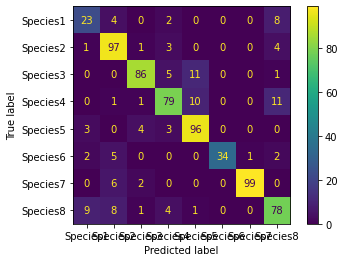

              precision    recall  f1-score   support

    Species1       0.61      0.62      0.61        37
    Species2       0.80      0.92      0.85       106
    Species3       0.91      0.83      0.87       103
    Species4       0.82      0.77      0.80       102
    Species5       0.81      0.91      0.86       106
    Species6       1.00      0.77      0.87        44
    Species7       0.99      0.93      0.96       107
    Species8       0.75      0.77      0.76       101

    accuracy                           0.84       706
   macro avg       0.84      0.82      0.82       706
weighted avg       0.84      0.84      0.84       706



In [ ]:
testModel(valid_gen, m3)

In [ ]:
m4 = tfk.models.load_model("savedModels/CNN_VGG16_3_FineTuning")

In [ ]:
m4.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-7), metrics='accuracy')
m4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 512)               2359808   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_VGG16_4_FineTuning')

# Train the model
history = m4.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 22s 234ms/step - loss: 3.8032 - accuracy: 0.8138 - val_loss: 0.5771 - val_accuracy: 0.7776
Epoch 2/200
89/89 [==============================] - 22s 242ms/step - loss: 3.7699 - accuracy: 0.8166 - val_loss: 0.5798 - val_accuracy: 0.7720
Epoch 3/200
89/89 [==============================] - 22s 251ms/step - loss: 3.8292 - accuracy: 0.8145 - val_loss: 0.5855 - val_accuracy: 0.7705
Epoch 4/200
89/89 [==============================] - 21s 238ms/step - loss: 3.7684 - accuracy: 0.8177 - val_loss: 0.5905 - val_accuracy: 0.7663
Epoch 5/200
89/89 [==============================] - 21s 237ms/step - loss: 3.9205 - accuracy: 0.8184 - val_loss: 0.5874 - val_accuracy: 0.7705
Epoch 6/200
89/89 [==============================] - 22s 250ms/step - loss: 3.8791 - accuracy: 0.8202 - val_loss: 0.5875 - val_accuracy: 0.7691
Epoch 7/200
89/89 [==============================] - 21s 237ms/step - loss: 3.9275 - accuracy: 0.8209 - val_loss: 0.5853 - val_accuracy:

In [ ]:
# Save best epoch model
m4.save("savedModels/CNN_VGG16_4_FineTuning")

706/706 [==============================] - 4s 5ms/step


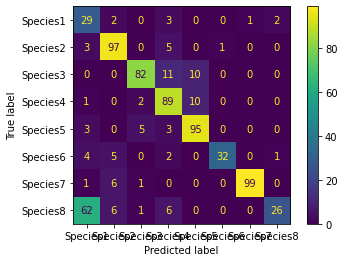

              precision    recall  f1-score   support

    Species1       0.28      0.78      0.41        37
    Species2       0.84      0.92      0.87       106
    Species3       0.90      0.80      0.85       103
    Species4       0.75      0.87      0.81       102
    Species5       0.83      0.90      0.86       106
    Species6       0.97      0.73      0.83        44
    Species7       0.99      0.93      0.96       107
    Species8       0.90      0.26      0.40       101

    accuracy                           0.78       706
   macro avg       0.81      0.77      0.75       706
weighted avg       0.84      0.78      0.78       706



In [ ]:
testModel(valid_gen, m4)

#VGG19


In [ ]:
supernet9 = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
for layer in supernet9.layers:
    layer.trainable = False

In [ ]:
vgg19 = build_model3(input_shape, supernet9)
vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               2359808   
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_13 (Dropout)        (None, 256)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_Vgg19')

# Train the model
history = vgg19.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 24s 259ms/step - loss: 16.6543 - accuracy: 0.2408 - val_loss: 1.6021 - val_accuracy: 0.3697
Epoch 2/200
89/89 [==============================] - 22s 247ms/step - loss: 13.9311 - accuracy: 0.3367 - val_loss: 1.4808 - val_accuracy: 0.4603
Epoch 3/200
89/89 [==============================] - 27s 303ms/step - loss: 13.0202 - accuracy: 0.3741 - val_loss: 1.4630 - val_accuracy: 0.4348
Epoch 4/200
89/89 [==============================] - 22s 252ms/step - loss: 12.6686 - accuracy: 0.4062 - val_loss: 1.3947 - val_accuracy: 0.4858
Epoch 5/200
89/89 [==============================] - 22s 248ms/step - loss: 12.6357 - accuracy: 0.4076 - val_loss: 1.3504 - val_accuracy: 0.4873
Epoch 6/200
89/89 [==============================] - 23s 256ms/step - loss: 12.1366 - accuracy: 0.4323 - val_loss: 1.3605 - val_accuracy: 0.4632
Epoch 7/200
89/89 [==============================] - 22s 251ms/step - loss: 12.2656 - accuracy: 0.4274 - val_loss: 1.3951 - val_ac

In [ ]:
# Save best epoch model
vgg19.save("savedModels/CNN_Vgg19")

706/706 [==============================] - 5s 7ms/step


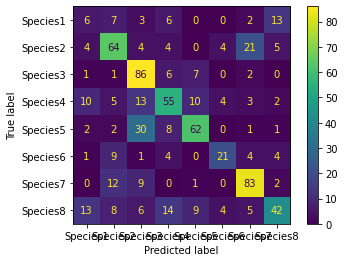

              precision    recall  f1-score   support

    Species1       0.16      0.16      0.16        37
    Species2       0.59      0.60      0.60       106
    Species3       0.57      0.83      0.67       103
    Species4       0.57      0.54      0.55       102
    Species5       0.70      0.58      0.64       106
    Species6       0.64      0.48      0.55        44
    Species7       0.69      0.78      0.73       107
    Species8       0.61      0.42      0.49       101

    accuracy                           0.59       706
   macro avg       0.56      0.55      0.55       706
weighted avg       0.60      0.59      0.59       706



In [ ]:
testModel(valid_gen, vgg19)

In [ ]:
vgg19_2 = tfk.models.load_model("savedModels/CNN_Vgg19")

In [ ]:
vgg19_2.get_layer('vgg19').trainable = True

In [ ]:
vgg19_2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
vgg19_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               2359808   
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_13 (Dropout)        (None, 256)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_VGG19_1_FineTuning')

# Train the model
history = vgg19_2.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 27s 281ms/step - loss: 17.0364 - accuracy: 0.1760 - val_loss: 1.9016 - val_accuracy: 0.2436
Epoch 2/200
89/89 [==============================] - 24s 269ms/step - loss: 15.7420 - accuracy: 0.2352 - val_loss: 1.6592 - val_accuracy: 0.3371
Epoch 3/200
89/89 [==============================] - 26s 288ms/step - loss: 14.6554 - accuracy: 0.2870 - val_loss: 1.6995 - val_accuracy: 0.2932
Epoch 4/200
89/89 [==============================] - 25s 276ms/step - loss: 13.5844 - accuracy: 0.3195 - val_loss: 1.8338 - val_accuracy: 0.2989
Epoch 5/200
89/89 [==============================] - 25s 278ms/step - loss: 13.6063 - accuracy: 0.3336 - val_loss: 1.6188 - val_accuracy: 0.3683
Epoch 6/200
89/89 [==============================] - 25s 278ms/step - loss: 12.3653 - accuracy: 0.3886 - val_loss: 1.5812 - val_accuracy: 0.4150
Epoch 7/200
89/89 [==============================] - 25s 282ms/step - loss: 12.1970 - accuracy: 0.4270 - val_loss: 1.3373 - val_ac

In [ ]:
# Save best epoch model
vgg19_2.save("savedModels/CNN_XCeption_1_FineTuning")

706/706 [==============================] - 5s 7ms/step


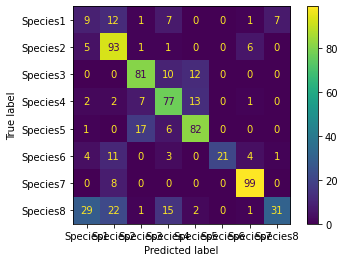

              precision    recall  f1-score   support

    Species1       0.18      0.24      0.21        37
    Species2       0.63      0.88      0.73       106
    Species3       0.75      0.79      0.77       103
    Species4       0.65      0.75      0.70       102
    Species5       0.75      0.77      0.76       106
    Species6       1.00      0.48      0.65        44
    Species7       0.88      0.93      0.90       107
    Species8       0.79      0.31      0.44       101

    accuracy                           0.70       706
   macro avg       0.70      0.64      0.64       706
weighted avg       0.73      0.70      0.69       706



In [ ]:
testModel(valid_gen, vgg19_2)

In [ ]:
vgg19_3 = tfk.models.load_model("savedModels/CNN_XCeption_1_FineTuning")

In [ ]:
vgg19_3.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')


In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_VGG19_2_FineTuning')

# Train the model
history = vgg19_3.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 28s 285ms/step - loss: 6.8158 - accuracy: 0.7193 - val_loss: 0.8028 - val_accuracy: 0.6941
Epoch 2/200
89/89 [==============================] - 25s 286ms/step - loss: 6.6776 - accuracy: 0.7169 - val_loss: 0.7730 - val_accuracy: 0.6926
Epoch 3/200
89/89 [==============================] - 24s 275ms/step - loss: 6.3338 - accuracy: 0.7377 - val_loss: 0.7846 - val_accuracy: 0.6955
Epoch 4/200
89/89 [==============================] - 25s 279ms/step - loss: 6.2650 - accuracy: 0.7239 - val_loss: 0.7940 - val_accuracy: 0.6983
Epoch 5/200
89/89 [==============================] - 24s 267ms/step - loss: 6.1311 - accuracy: 0.7359 - val_loss: 0.8168 - val_accuracy: 0.6785
Epoch 6/200
89/89 [==============================] - 24s 275ms/step - loss: 6.0589 - accuracy: 0.7482 - val_loss: 0.7826 - val_accuracy: 0.6997
Epoch 7/200
89/89 [==============================] - 24s 266ms/step - loss: 5.9324 - accuracy: 0.7429 - val_loss: 0.7468 - val_accuracy:

In [ ]:
# Save best epoch model
vgg19_3.save("savedModels/CNN_XCeption_2_FineTuning")

706/706 [==============================] - 5s 7ms/step


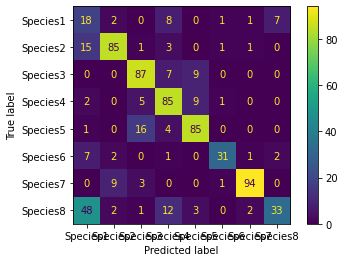

              precision    recall  f1-score   support

    Species1       0.20      0.49      0.28        37
    Species2       0.85      0.80      0.83       106
    Species3       0.77      0.84      0.81       103
    Species4       0.71      0.83      0.77       102
    Species5       0.80      0.80      0.80       106
    Species6       0.89      0.70      0.78        44
    Species7       0.95      0.88      0.91       107
    Species8       0.79      0.33      0.46       101

    accuracy                           0.73       706
   macro avg       0.74      0.71      0.70       706
weighted avg       0.78      0.73      0.74       706



In [ ]:
testModel(valid_gen, vgg19_3)

#XCeption

In [48]:
supernet2 = tfk.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

In [49]:
for layer in supernet2.layers:
    layer.trainable = False

In [46]:
xCeption = build_model3(input_shape, supernet2)
xCeption.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_XCeption')

# Train the model
history = xCeption.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 30s 310ms/step - loss: 17.5881 - accuracy: 0.2482 - val_loss: 1.7035 - val_accuracy: 0.3810
Epoch 2/200
89/89 [==============================] - 27s 300ms/step - loss: 14.9561 - accuracy: 0.3166 - val_loss: 1.5201 - val_accuracy: 0.4462
Epoch 3/200
89/89 [==============================] - 26s 296ms/step - loss: 14.0343 - accuracy: 0.3484 - val_loss: 1.4753 - val_accuracy: 0.4462
Epoch 4/200
89/89 [==============================] - 28s 321ms/step - loss: 13.4627 - accuracy: 0.3791 - val_loss: 1.4683 - val_accuracy: 0.4221
Epoch 5/200
89/89 [==============================] - 26s 291ms/step - loss: 13.3831 - accuracy: 0.3812 - val_loss: 1.4386 - val_accuracy: 0.4476
Epoch 6/200
89/89 [==============================] - 27s 305ms/step - loss: 13.0694 - accuracy: 0.4080 - val_loss: 1.3990 - val_accuracy: 0.4844
Epoch 7/200
89/89 [==============================] - 26s 295ms/step - loss: 12.6067 - accuracy: 0.4189 - val_loss: 1.4538 - val_ac

KeyboardInterrupt: ignored

In [ ]:
# Save best epoch model
xCeption.save("savedModels/CNN_XCeption")

In [ ]:
testModel(valid_gen, xCeption)

706/706 [==============================] - 7s 9ms/step


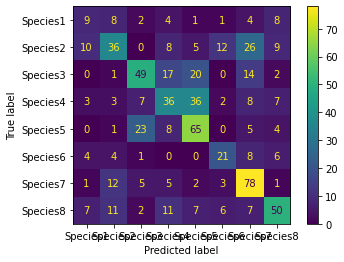

              precision    recall  f1-score   support

    Species1       0.26      0.24      0.25        37
    Species2       0.47      0.34      0.40       106
    Species3       0.55      0.48      0.51       103
    Species4       0.40      0.35      0.38       102
    Species5       0.48      0.61      0.54       106
    Species6       0.47      0.48      0.47        44
    Species7       0.52      0.73      0.61       107
    Species8       0.57      0.50      0.53       101

    accuracy                           0.49       706
   macro avg       0.47      0.47      0.46       706
weighted avg       0.49      0.49      0.48       706



In [ ]:
testModel(valid_gen, xCeption) #with roumor

706/706 [==============================] - 6s 8ms/step


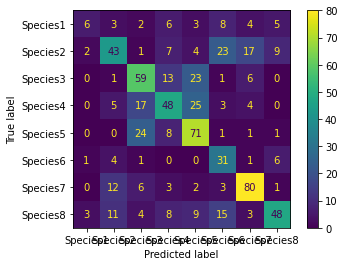

              precision    recall  f1-score   support

    Species1       0.50      0.16      0.24        37
    Species2       0.54      0.41      0.46       106
    Species3       0.52      0.57      0.54       103
    Species4       0.52      0.47      0.49       102
    Species5       0.52      0.67      0.58       106
    Species6       0.36      0.70      0.48        44
    Species7       0.69      0.75      0.72       107
    Species8       0.69      0.48      0.56       101

    accuracy                           0.55       706
   macro avg       0.54      0.53      0.51       706
weighted avg       0.56      0.55      0.54       706



In [ ]:
#this is with roumor in the imgs
testModel(valid_gen, xCeption)

In [ ]:
xc = tfk.models.load_model("savedModels/CNN_XCeption")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
xc.get_layer('xception').trainable = True

In [ ]:
xc.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
xc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_XCeption_1_FineTuning')

# Train the model
history = xc.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 44s 418ms/step - loss: 15.4782 - accuracy: 0.2405 - val_loss: 1.6241 - val_accuracy: 0.4037
Epoch 2/200
89/89 [==============================] - 32s 363ms/step - loss: 14.3611 - accuracy: 0.3071 - val_loss: 1.3370 - val_accuracy: 0.5014
Epoch 3/200
89/89 [==============================] - 31s 354ms/step - loss: 13.5145 - accuracy: 0.3628 - val_loss: 1.3018 - val_accuracy: 0.5028
Epoch 4/200
89/89 [==============================] - 30s 336ms/step - loss: 13.5222 - accuracy: 0.3547 - val_loss: 1.1803 - val_accuracy: 0.5581
Epoch 5/200
89/89 [==============================] - 31s 352ms/step - loss: 13.0123 - accuracy: 0.3787 - val_loss: 1.1049 - val_accuracy: 0.6232
Epoch 6/200
89/89 [==============================] - 33s 373ms/step - loss: 12.6746 - accuracy: 0.4136 - val_loss: 1.2643 - val_accuracy: 0.5992
Epoch 7/200
89/89 [==============================] - 31s 351ms/step - loss: 12.2222 - accuracy: 0.4203 - val_loss: 1.0989 - val_ac

In [ ]:
# Save best epoch model
xc.save("savedModels/CNN_XCeption_1_FineTuning")

706/706 [==============================] - 8s 11ms/step


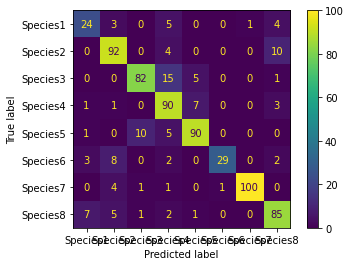

              precision    recall  f1-score   support

    Species1       0.67      0.65      0.66        37
    Species2       0.81      0.87      0.84       106
    Species3       0.87      0.80      0.83       103
    Species4       0.73      0.88      0.80       102
    Species5       0.87      0.85      0.86       106
    Species6       0.97      0.66      0.78        44
    Species7       0.99      0.93      0.96       107
    Species8       0.81      0.84      0.83       101

    accuracy                           0.84       706
   macro avg       0.84      0.81      0.82       706
weighted avg       0.85      0.84      0.84       706



In [ ]:
testModel(valid_gen, xc)

706/706 [==============================] - 7s 8ms/step


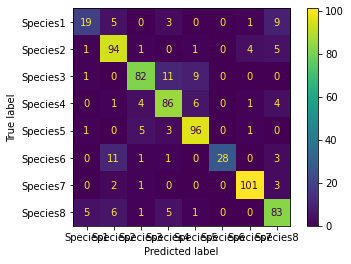

              precision    recall  f1-score   support

    Species1       0.70      0.51      0.59        37
    Species2       0.79      0.89      0.84       106
    Species3       0.86      0.80      0.83       103
    Species4       0.79      0.84      0.82       102
    Species5       0.85      0.91      0.88       106
    Species6       1.00      0.64      0.78        44
    Species7       0.94      0.94      0.94       107
    Species8       0.78      0.82      0.80       101

    accuracy                           0.83       706
   macro avg       0.84      0.79      0.81       706
weighted avg       0.84      0.83      0.83       706



In [ ]:
testModel(valid_gen, xc)

706/706 [==============================] - 398s 554ms/step


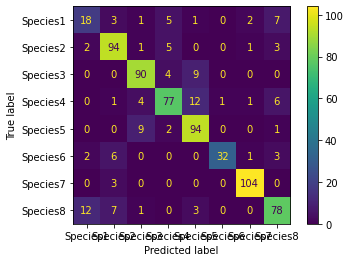

              precision    recall  f1-score   support

    Species1       0.53      0.49      0.51        37
    Species2       0.82      0.89      0.85       106
    Species3       0.85      0.87      0.86       103
    Species4       0.83      0.75      0.79       102
    Species5       0.79      0.89      0.84       106
    Species6       0.97      0.73      0.83        44
    Species7       0.95      0.97      0.96       107
    Species8       0.80      0.77      0.78       101

    accuracy                           0.83       706
   macro avg       0.82      0.80      0.80       706
weighted avg       0.83      0.83      0.83       706



In [ ]:
testModel(valid_gen, xc) #with roumors

In [ ]:
xc2 = tfk.models.load_model("savedModels/CNN_XCeption_1_FineTuning")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
xc2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_XCeption_2_FineTuning')

# Train the model
history = xc2.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 1485s 17s/step - loss: 6.8598 - accuracy: 0.7070 - val_loss: 0.4807 - val_accuracy: 0.8385
Epoch 2/200
89/89 [==============================] - 29s 328ms/step - loss: 7.0714 - accuracy: 0.6869 - val_loss: 0.4764 - val_accuracy: 0.8300
Epoch 3/200
89/89 [==============================] - 29s 329ms/step - loss: 6.7882 - accuracy: 0.7123 - val_loss: 0.4996 - val_accuracy: 0.8272
Epoch 4/200
89/89 [==============================] - 28s 319ms/step - loss: 7.1253 - accuracy: 0.6961 - val_loss: 0.4877 - val_accuracy: 0.8272
Epoch 5/200
89/89 [==============================] - 28s 310ms/step - loss: 6.9024 - accuracy: 0.7077 - val_loss: 0.4942 - val_accuracy: 0.8314
Epoch 6/200
89/89 [==============================] - 28s 319ms/step - loss: 6.6702 - accuracy: 0.7098 - val_loss: 0.4952 - val_accuracy: 0.8314
Epoch 7/200
89/89 [==============================] - 29s 324ms/step - loss: 6.7454 - accuracy: 0.7042 - val_loss: 0.4892 - val_accuracy:

In [ ]:
# Save best epoch model
xc2.save("savedModels/CNN_XCeption_2_FineTuning")

706/706 [==============================] - 7s 9ms/step


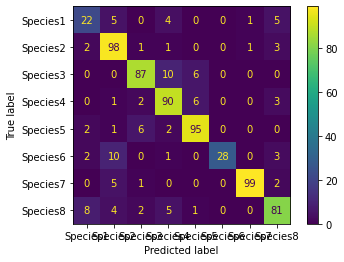

              precision    recall  f1-score   support

    Species1       0.61      0.59      0.60        37
    Species2       0.79      0.92      0.85       106
    Species3       0.88      0.84      0.86       103
    Species4       0.80      0.88      0.84       102
    Species5       0.88      0.90      0.89       106
    Species6       1.00      0.64      0.78        44
    Species7       0.98      0.93      0.95       107
    Species8       0.84      0.80      0.82       101

    accuracy                           0.85       706
   macro avg       0.85      0.81      0.82       706
weighted avg       0.86      0.85      0.85       706



In [ ]:
testModel(valid_gen, xc2)

706/706 [==============================] - 6s 8ms/step


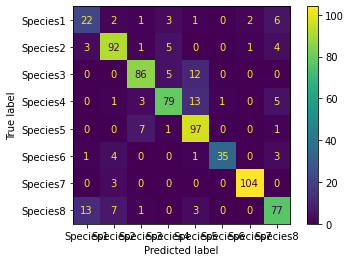

              precision    recall  f1-score   support

    Species1       0.56      0.59      0.58        37
    Species2       0.84      0.87      0.86       106
    Species3       0.87      0.83      0.85       103
    Species4       0.85      0.77      0.81       102
    Species5       0.76      0.92      0.83       106
    Species6       0.97      0.80      0.88        44
    Species7       0.97      0.97      0.97       107
    Species8       0.80      0.76      0.78       101

    accuracy                           0.84       706
   macro avg       0.83      0.81      0.82       706
weighted avg       0.84      0.84      0.84       706



In [ ]:
testModel(valid_gen, xc2) #with roumors

In [ ]:
xc3 = tfk.models.load_model("savedModels/CNN_XCeption_2_FineTuning")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0     

In [ ]:
xc3.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-6), metrics='accuracy')


In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_XCeption_3_FineTuning')

# Train the model
history = xc3.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 38s 365ms/step - loss: 2.1646 - accuracy: 0.9006 - val_loss: 0.5932 - val_accuracy: 0.8442
Epoch 2/200
89/89 [==============================] - 28s 310ms/step - loss: 2.1868 - accuracy: 0.9051 - val_loss: 0.5902 - val_accuracy: 0.8414
Epoch 3/200
89/89 [==============================] - 28s 320ms/step - loss: 2.2359 - accuracy: 0.9090 - val_loss: 0.5860 - val_accuracy: 0.8442
Epoch 4/200
89/89 [==============================] - 28s 316ms/step - loss: 2.3914 - accuracy: 0.9034 - val_loss: 0.5962 - val_accuracy: 0.8385
Epoch 5/200
89/89 [==============================] - 27s 306ms/step - loss: 2.2832 - accuracy: 0.9044 - val_loss: 0.5893 - val_accuracy: 0.8399
Epoch 6/200
89/89 [==============================] - 27s 303ms/step - loss: 2.4685 - accuracy: 0.9006 - val_loss: 0.5973 - val_accuracy: 0.8414
Epoch 7/200
89/89 [==============================] - 27s 302ms/step - loss: 2.1872 - accuracy: 0.9044 - val_loss: 0.5862 - val_accuracy:

In [ ]:
# Save best epoch model
xc3.save("savedModels/CNN_XCeption_3_FineTuning")

706/706 [==============================] - 7s 9ms/step


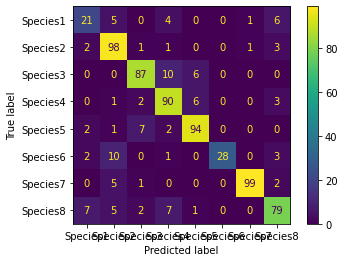

              precision    recall  f1-score   support

    Species1       0.62      0.57      0.59        37
    Species2       0.78      0.92      0.85       106
    Species3       0.87      0.84      0.86       103
    Species4       0.78      0.88      0.83       102
    Species5       0.88      0.89      0.88       106
    Species6       1.00      0.64      0.78        44
    Species7       0.98      0.93      0.95       107
    Species8       0.82      0.78      0.80       101

    accuracy                           0.84       706
   macro avg       0.84      0.81      0.82       706
weighted avg       0.85      0.84      0.84       706



In [ ]:
testModel(valid_gen, xc3)

#InceptionV3

In [ ]:
supernet3 = tfk.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

In [ ]:
for layer in supernet3.layers:
    layer.trainable = False

In [ ]:
inceptionV3 = build_model4(input_shape, supernet3)
inceptionV3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 Flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 1028)              2106372   
                                                                 
 dropout_8 (Dropout)         (None, 1028)              0         
                                                                 
 Classifier (Dense)          (None, 1028)              1057812   
                                                                 
 dropout_9 (Dropout)         (None, 1028)              0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_inceptionV3')

# Train the model
history = inceptionV3.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 35s 351ms/step - loss: 22.2073 - accuracy: 0.1929 - val_loss: 1.9860 - val_accuracy: 0.1898
Epoch 2/200
89/89 [==============================] - 28s 318ms/step - loss: 15.7854 - accuracy: 0.2073 - val_loss: 1.8778 - val_accuracy: 0.2040
Epoch 3/200
89/89 [==============================] - 29s 331ms/step - loss: 15.6552 - accuracy: 0.2035 - val_loss: 1.8787 - val_accuracy: 0.1969
Epoch 4/200
89/89 [==============================] - 28s 321ms/step - loss: 15.7226 - accuracy: 0.2190 - val_loss: 1.8713 - val_accuracy: 0.2195
Epoch 5/200
89/89 [==============================] - 29s 323ms/step - loss: 15.5490 - accuracy: 0.2035 - val_loss: 1.8569 - val_accuracy: 0.2025
Epoch 6/200
89/89 [==============================] - 29s 324ms/step - loss: 15.4306 - accuracy: 0.2207 - val_loss: 1.8727 - val_accuracy: 0.2110
Epoch 7/200
89/89 [==============================] - 29s 326ms/step - loss: 15.5357 - accuracy: 0.2130 - val_loss: 1.8714 - val_ac

KeyboardInterrupt: ignored

In [ ]:
# Save best epoch model
inceptionV3.save("savedModels/CNN_inceptionV3")

706/706 [==============================] - 10s 13ms/step


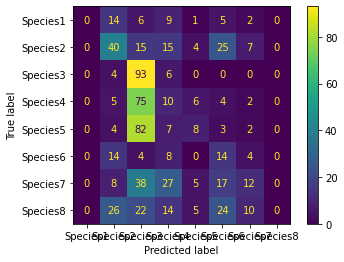

              precision    recall  f1-score   support

    Species1       0.00      0.00      0.00        37
    Species2       0.35      0.38      0.36       106
    Species3       0.28      0.90      0.42       103
    Species4       0.10      0.10      0.10       102
    Species5       0.28      0.08      0.12       106
    Species6       0.15      0.32      0.21        44
    Species7       0.31      0.11      0.16       107
    Species8       0.00      0.00      0.00       101

    accuracy                           0.25       706
   macro avg       0.18      0.24      0.17       706
weighted avg       0.21      0.25      0.19       706



In [ ]:
testModel(valid_gen, inceptionV3)

In [ ]:
iv3 = tfk.models.load_model("savedModels/CNN_inceptionV3")
iv3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 Flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Classifier (Dense)          (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(supernet3.layers):
   print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 240 layers and unfreeze the rest:
for layer in iv3.layers[:240]:
   layer.trainable = False
for layer in iv3.layers[240:]:
   layer.trainable = True

In [ ]:
iv3.get_layer('inception_v3').trainable = True


In [ ]:
iv3.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
iv3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 Flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Classifier (Dense)          (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_inceptionV3_FineTuning')

# Train the model
history = iv3.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 942s 10s/step - loss: 15.5603 - accuracy: 0.2408 - val_loss: 1.6870 - val_accuracy: 0.3725
Epoch 2/200
89/89 [==============================] - 29s 329ms/step - loss: 13.8575 - accuracy: 0.3378 - val_loss: 4.8900 - val_accuracy: 0.3569
Epoch 3/200
89/89 [==============================] - 29s 326ms/step - loss: 12.6845 - accuracy: 0.4140 - val_loss: 1.5634 - val_accuracy: 0.4433
Epoch 4/200
89/89 [==============================] - 29s 328ms/step - loss: 12.0126 - accuracy: 0.4538 - val_loss: 2.4988 - val_accuracy: 0.5000
Epoch 5/200
89/89 [==============================] - 29s 328ms/step - loss: 11.5958 - accuracy: 0.4739 - val_loss: 1.3919 - val_accuracy: 0.4717
Epoch 6/200
89/89 [==============================] - 29s 324ms/step - loss: 11.0839 - accuracy: 0.5095 - val_loss: 4.7079 - val_accuracy: 0.4235
Epoch 7/200
89/89 [==============================] - 28s 319ms/step - loss: 10.7816 - accuracy: 0.5293 - val_loss: 1.2065 - val_acc

In [ ]:
iv3.save("savedModels/CNN_inceptionV3_FineTuning")

706/706 [==============================] - 17s 21ms/step


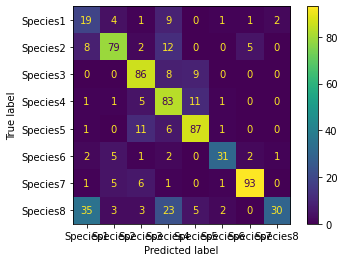

              precision    recall  f1-score   support

    Species1       0.28      0.51      0.37        37
    Species2       0.81      0.75      0.78       106
    Species3       0.75      0.83      0.79       103
    Species4       0.58      0.81      0.67       102
    Species5       0.78      0.82      0.80       106
    Species6       0.84      0.70      0.77        44
    Species7       0.92      0.87      0.89       107
    Species8       0.91      0.30      0.45       101

    accuracy                           0.72       706
   macro avg       0.73      0.70      0.69       706
weighted avg       0.77      0.72      0.72       706



In [ ]:
testModel(valid_gen, iv3)

In [ ]:
iv3_2 = tfk.models.load_model("savedModels/CNN_inceptionV3_FineTuning")

In [ ]:
iv3_2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')
iv3_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 Flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Classifier (Dense)          (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_inceptionV3_2_FineTuning')

# Train the model
history = iv3_2.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 38s 338ms/step - loss: 7.9519 - accuracy: 0.6492 - val_loss: 0.7810 - val_accuracy: 0.7025
Epoch 2/200
89/89 [==============================] - 29s 329ms/step - loss: 7.8292 - accuracy: 0.6516 - val_loss: 0.7915 - val_accuracy: 0.6983
Epoch 3/200
89/89 [==============================] - 29s 331ms/step - loss: 7.6046 - accuracy: 0.6474 - val_loss: 0.8020 - val_accuracy: 0.6926
Epoch 4/200
89/89 [==============================] - 29s 322ms/step - loss: 7.5919 - accuracy: 0.6594 - val_loss: 0.8008 - val_accuracy: 0.6912
Epoch 5/200
89/89 [==============================] - 29s 322ms/step - loss: 7.5871 - accuracy: 0.6569 - val_loss: 0.8015 - val_accuracy: 0.6926
Epoch 6/200
89/89 [==============================] - 30s 333ms/step - loss: 7.5264 - accuracy: 0.6626 - val_loss: 0.8012 - val_accuracy: 0.6955
Epoch 7/200
89/89 [==============================] - 29s 328ms/step - loss: 7.3924 - accuracy: 0.6696 - val_loss: 0.8152 - val_accuracy:

In [ ]:
iv3_2.save("savedModels/CNN_inceptionV3_2_FineTuning")

706/706 [==============================] - 13s 16ms/step


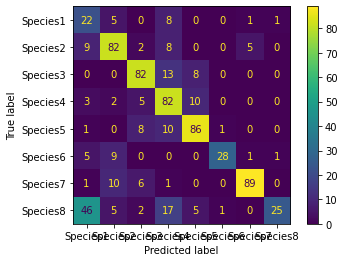

              precision    recall  f1-score   support

    Species1       0.25      0.59      0.35        37
    Species2       0.73      0.77      0.75       106
    Species3       0.78      0.80      0.79       103
    Species4       0.59      0.80      0.68       102
    Species5       0.79      0.81      0.80       106
    Species6       0.93      0.64      0.76        44
    Species7       0.93      0.83      0.88       107
    Species8       0.93      0.25      0.39       101

    accuracy                           0.70       706
   macro avg       0.74      0.69      0.67       706
weighted avg       0.77      0.70      0.70       706



In [ ]:
testModel(valid_gen, iv3_2)

#ResNet

In [ ]:
supernet4 = tfk.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
for layer in supernet4.layers:
    layer.trainable = False

In [ ]:
resNet = build_model4(input_shape, supernet4)
resNet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_resNet50')

# Train the model
history = resNet.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 32s 332ms/step - loss: 17.4509 - accuracy: 0.1372 - val_loss: 2.0436 - val_accuracy: 0.2564
Epoch 2/200
89/89 [==============================] - 28s 317ms/step - loss: 16.2530 - accuracy: 0.1707 - val_loss: 1.9685 - val_accuracy: 0.2394
Epoch 3/200
89/89 [==============================] - 27s 306ms/step - loss: 16.1479 - accuracy: 0.1590 - val_loss: 1.9958 - val_accuracy: 0.2266
Epoch 4/200
89/89 [==============================] - 28s 316ms/step - loss: 16.0963 - accuracy: 0.1925 - val_loss: 1.9718 - val_accuracy: 0.2365
Epoch 5/200
89/89 [==============================] - 29s 329ms/step - loss: 16.0104 - accuracy: 0.1823 - val_loss: 1.9536 - val_accuracy: 0.2238
Epoch 6/200
89/89 [==============================] - 27s 303ms/step - loss: 15.8329 - accuracy: 0.1978 - val_loss: 1.9244 - val_accuracy: 0.2252
Epoch 7/200
89/89 [==============================] - 29s 323ms/step - loss: 15.7925 - accuracy: 0.1869 - val_loss: 1.9001 - val_ac

KeyboardInterrupt: ignored

In [ ]:
# Save best epoch model
resNet.save("savedModels/CNN_resNet50")

In [ ]:
testModel(valid_gen, resNet)

In [ ]:
rn = tfk.models.load_model("savedModels/CNN_resNet50")
rn.summary()

In [ ]:
rn.get_layer('xception').trainable = True

In [ ]:
rn.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
rn.summary()

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_resNet50_FineTuning')

# Train the model
history = rn.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
rn.save("savedModels/CNN_resNet50_FineTuning")

In [ ]:
testModel(valid_gen, rn)

#EfficientNetB4

In [ ]:
supernet5 = tfk.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

71686520/71686520 [==============================] - 3s 0us/step


In [ ]:
for layer in supernet5.layers:
    layer.trainable = False

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb4 (Functional)  (None, 3, 3, 1792)       17673823  
                                                                 
 Flatten (Flatten)           (None, 16128)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               8258048   
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_15 (Dropout)        (None, 256)               0     

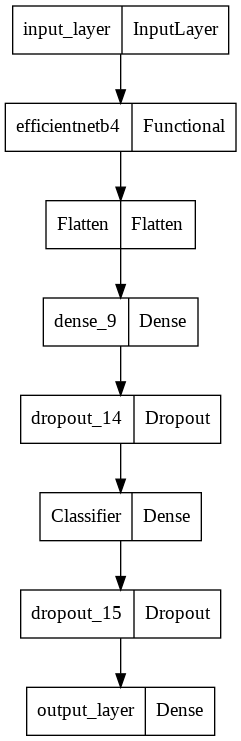

In [ ]:
effNetB4 = build_model3(input_shape, supernet5)
effNetB4.summary()
tfk.utils.plot_model(effNetB4)

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_effNetB4')

# Train the model
history = effNetB4.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 51s 438ms/step - loss: 23.8427 - accuracy: 0.1333 - val_loss: 2.0794 - val_accuracy: 0.1445
Epoch 2/200
89/89 [==============================] - 35s 392ms/step - loss: 16.6818 - accuracy: 0.1453 - val_loss: 2.0791 - val_accuracy: 0.1431
Epoch 3/200
89/89 [==============================] - 34s 379ms/step - loss: 16.6545 - accuracy: 0.1389 - val_loss: 2.0781 - val_accuracy: 0.1431
Epoch 4/200
89/89 [==============================] - 34s 388ms/step - loss: 16.6406 - accuracy: 0.1365 - val_loss: 2.0791 - val_accuracy: 0.1431
Epoch 5/200
89/89 [==============================] - 34s 379ms/step - loss: 16.6518 - accuracy: 0.1358 - val_loss: 2.0795 - val_accuracy: 0.1431
Epoch 6/200
89/89 [==============================] - 42s 474ms/step - loss: 16.6424 - accuracy: 0.1347 - val_loss: 2.0794 - val_accuracy: 0.1431
Epoch 7/200
89/89 [==============================] - 34s 380ms/step - loss: 16.6412 - accuracy: 0.1365 - val_loss: 2.0789 - val_ac

KeyboardInterrupt: ignored

In [ ]:
# Save best epoch model
effNetB4.save("savedModels/CNN_effNetB4")

In [ ]:
testModel(valid_gen, effNetB4)

In [ ]:
enb4 = tfk.models.load_model("savedModels/CNN_effNetB4")
enb4.summary()

In [ ]:
enb4.get_layer('xception').trainable = True

In [ ]:
enb4.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
enb4.summary()

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_effNetB4_FineTuning')

# Train the model
history = enb4.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
enb4.save("savedModels/CNN_effNetB4_FineTuning")

In [ ]:
testModel(valid_gen, enb4)

#Combine 2 model together

In [ ]:
first_model = tfk.models.load_model("savedModels/BestModel_1")
second_model = tfk.models.load_model("savedModels/CNN_XCeption_3_FineTuning")
third_model = tfk.models.load_model("savedModels/CNN_VGG16_2_FineTuning")

first_model._name = 'model1'
second_model._name = 'model2'
third_model._name = 'model3'

In [ ]:
models = [first_model, second_model, third_model]
model_input = tf.keras.Input(shape=input_shape, name='input_layer')
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
ensemble_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 model1 (Functional)            (None, 8)            17207880    ['input_layer[0][0]']            
                                                                                                  
 model2 (Functional)            (None, 8)            30432560    ['input_layer[0][0]']            
                                                                                                  
 model3 (Functional)            (None, 8)            20518784    ['input_layer[0][0]']            
                                                                                            

In [ ]:
def build_combine_model(input_shape):
  input_layer = tfkl.Input(shape=input_shape, name='input_layer')

  a = (input_layer/255)
  b = tf.keras.applications.mobilenet.preprocess_input(input_layer)

  x = first_model(a)
  y = second_model(a)

  avg = tf.keras.layers.Average()([x, y])

  combine_model = tfk.Model(inputs=input_layer, outputs=avg, name='Comb_model')

  return combine_model

In [ ]:
cmb_model = build_combine_model(input_shape)
cmb_model.summary()

Model: "Comb_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 96, 96, 3)    0           ['input_layer[0][0]']            
                                                                                                  
 model1 (Functional)            (None, 8)            17207880    ['tf.math.truediv[0][0]']        
                                                                                                  
 model2 (Functional)            (None, 8)            30432560    ['tf.math.truediv[0][0]']        
                                                                                         

In [ ]:
ensemble_model.save("savedModels/EnsambleModel_3")

706/706 [==============================] - 278s 394ms/step


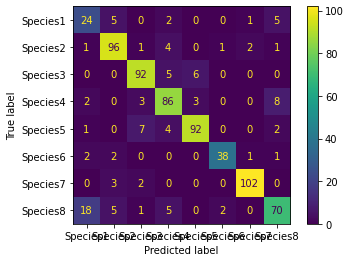

              precision    recall  f1-score   support

    Species1       0.50      0.65      0.56        37
    Species2       0.86      0.91      0.88       106
    Species3       0.87      0.89      0.88       103
    Species4       0.81      0.84      0.83       102
    Species5       0.91      0.87      0.89       106
    Species6       0.93      0.86      0.89        44
    Species7       0.96      0.95      0.96       107
    Species8       0.80      0.69      0.74       101

    accuracy                           0.85       706
   macro avg       0.83      0.83      0.83       706
weighted avg       0.86      0.85      0.85       706



In [ ]:
testModel(valid_gen, first_model)

706/706 [==============================] - 89s 126ms/step


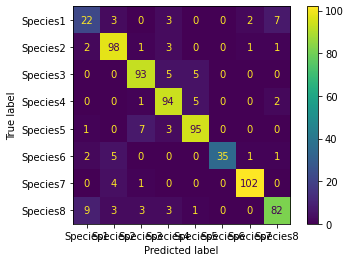

              precision    recall  f1-score   support

    Species1       0.61      0.59      0.60        37
    Species2       0.87      0.92      0.89       106
    Species3       0.88      0.90      0.89       103
    Species4       0.85      0.92      0.88       102
    Species5       0.90      0.90      0.90       106
    Species6       1.00      0.80      0.89        44
    Species7       0.96      0.95      0.96       107
    Species8       0.88      0.81      0.85       101

    accuracy                           0.88       706
   macro avg       0.87      0.85      0.86       706
weighted avg       0.88      0.88      0.88       706



In [ ]:
testModel(valid_gen, ensemble_model)

706/706 [==============================] - 233s 326ms/step


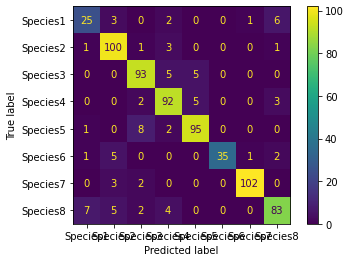

              precision    recall  f1-score   support

    Species1       0.71      0.68      0.69        37
    Species2       0.86      0.94      0.90       106
    Species3       0.86      0.90      0.88       103
    Species4       0.85      0.90      0.88       102
    Species5       0.90      0.90      0.90       106
    Species6       1.00      0.80      0.89        44
    Species7       0.98      0.95      0.97       107
    Species8       0.87      0.82      0.85       101

    accuracy                           0.89       706
   macro avg       0.88      0.86      0.87       706
weighted avg       0.89      0.89      0.88       706



In [ ]:
testModel(valid_gen, ensemble_model)

# AlexNet

In [ ]:
def build_alexNet_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=96,
        kernel_size=(11, 11),
        strides=(4, 4),
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    normalization1 = tfkl.BatchNormalization()(conv1)
    pool1 = tfkl.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(normalization1)

    conv2 = tfkl.Conv2D(
        filters=256,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    normalization2 = tfkl.BatchNormalization()(conv2)
    pool2 = tfkl.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(normalization2)

    conv3 = tfkl.Conv2D(
        filters=384,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    normalization3 = tfkl.BatchNormalization()(conv3)
    conv4 = tfkl.Conv2D(
        filters=384,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(normalization3)
    normalization4 = tfkl.BatchNormalization()(conv4)
    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(normalization4)
    normalization5 = tfkl.BatchNormalization()(conv5)
    pool3 = tfkl.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(normalization5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool3)
    dropout1 = tfkl.Dropout(0.5, seed=seed)(flattening_layer)
    dense_layer1 = tfkl.Dense(units=4096, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed))(dropout1)
    dropout2 = tfkl.Dropout(0.5, seed=seed)(dense_layer1)
    dense_layer2 = tfkl.Dense(units=4096, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed))(dropout2)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dense_layer2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(0.001), metrics='accuracy')

    # Return the model
    return model

In [ ]:
alexNet = build_alexNet_model(input_shape)
alexNet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_188 (Conv2D)         (None, 22, 22, 96)        34944     
                                                                 
 batch_normalization_188 (Ba  (None, 22, 22, 96)       384       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 10, 96)       0         
 2D)                                                             
                                                                 
 conv2d_189 (Conv2D)         (None, 10, 10, 256)       614656    
                                                                 
 batch_normalization_189 (Ba  (None, 10, 10, 256)      1024  

In [ ]:
import visualkeras

visualkeras.layered_view(alexNet)

ModuleNotFoundError: ignored

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_alexNet')

# Train the model
history = alexNet.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 22s 230ms/step - loss: 63.9939 - accuracy: 0.1738 - val_loss: 2.1876 - val_accuracy: 0.1728
Epoch 2/200
89/89 [==============================] - 20s 230ms/step - loss: 25.8180 - accuracy: 0.2239 - val_loss: 2.2210 - val_accuracy: 0.1601
Epoch 3/200
89/89 [==============================] - 20s 229ms/step - loss: 21.2901 - accuracy: 0.2451 - val_loss: 2.0262 - val_accuracy: 0.2040
Epoch 4/200
89/89 [==============================] - 19s 216ms/step - loss: 19.7221 - accuracy: 0.2599 - val_loss: 1.9221 - val_accuracy: 0.2507
Epoch 5/200
89/89 [==============================] - 19s 219ms/step - loss: 18.2640 - accuracy: 0.2927 - val_loss: 1.7837 - val_accuracy: 0.3470
Epoch 6/200
89/89 [==============================] - 20s 220ms/step - loss: 17.3639 - accuracy: 0.2987 - val_loss: 1.7005 - val_accuracy: 0.3626
Epoch 7/200
89/89 [==============================] - 20s 220ms/step - loss: 16.4252 - accuracy: 0.3050 - val_loss: 1.7214 - val_ac

In [ ]:
# Save best epoch model
alexNet.save("savedModels/CNN_alexNet")

706/706 [==============================] - 3s 4ms/step


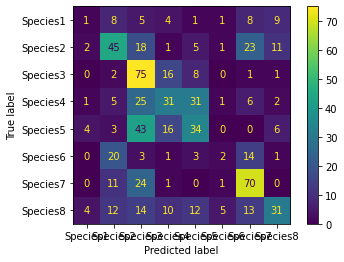

              precision    recall  f1-score   support

    Species1       0.08      0.03      0.04        37
    Species2       0.42      0.42      0.42       106
    Species3       0.36      0.73      0.48       103
    Species4       0.39      0.30      0.34       102
    Species5       0.36      0.32      0.34       106
    Species6       0.18      0.05      0.07        44
    Species7       0.52      0.65      0.58       107
    Species8       0.51      0.31      0.38       101

    accuracy                           0.41       706
   macro avg       0.35      0.35      0.33       706
weighted avg       0.39      0.41      0.38       706



In [ ]:
testModel(valid_gen, alexNet)

In [ ]:
testModel(valid_gen, alexNet)

In [ ]:
an = tfk.models.load_model("savedModels/CNN_alexNet")
an.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_188 (Conv2D)         (None, 22, 22, 96)        34944     
                                                                 
 batch_normalization_188 (Ba  (None, 22, 22, 96)       384       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 10, 96)       0         
 2D)                                                             
                                                                 
 conv2d_189 (Conv2D)         (None, 10, 10, 256)       614656    
                                                                 
 batch_normalization_189 (Ba  (None, 10, 10, 256)      1024  

In [ ]:
an.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(0.0001), metrics='accuracy')

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_alexNet')

# Train the model
history = an.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 20s 222ms/step - loss: 14.9700 - accuracy: 0.3466 - val_loss: 1.6598 - val_accuracy: 0.3470
Epoch 2/200
89/89 [==============================] - 19s 217ms/step - loss: 14.7012 - accuracy: 0.3508 - val_loss: 1.7557 - val_accuracy: 0.3102
Epoch 3/200
89/89 [==============================] - 19s 218ms/step - loss: 14.9734 - accuracy: 0.3382 - val_loss: 1.7359 - val_accuracy: 0.3201
Epoch 4/200
89/89 [==============================] - 20s 225ms/step - loss: 14.7233 - accuracy: 0.3417 - val_loss: 1.8046 - val_accuracy: 0.3003
Epoch 5/200
89/89 [==============================] - 19s 215ms/step - loss: 14.5589 - accuracy: 0.3445 - val_loss: 1.8012 - val_accuracy: 0.2989
Epoch 6/200
89/89 [==============================] - 19s 220ms/step - loss: 14.4878 - accuracy: 0.3516 - val_loss: 1.7885 - val_accuracy: 0.3074
Epoch 7/200
89/89 [==============================] - 20s 228ms/step - loss: 14.6058 - accuracy: 0.3667 - val_loss: 1.7581 - val_ac

In [ ]:
# Save best epoch model
an.save("savedModels/CNN_alexNet_2")

706/706 [==============================] - 3s 4ms/step


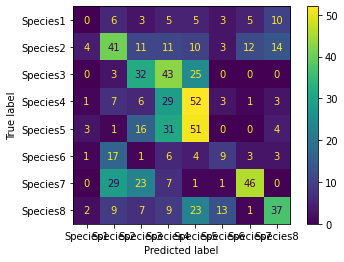

              precision    recall  f1-score   support

    Species1       0.00      0.00      0.00        37
    Species2       0.36      0.39      0.37       106
    Species3       0.32      0.31      0.32       103
    Species4       0.21      0.28      0.24       102
    Species5       0.30      0.48      0.37       106
    Species6       0.28      0.20      0.24        44
    Species7       0.68      0.43      0.53       107
    Species8       0.52      0.37      0.43       101

    accuracy                           0.35       706
   macro avg       0.33      0.31      0.31       706
weighted avg       0.37      0.35      0.35       706



In [ ]:
testModel(valid_gen, an)

In [ ]:
axn = tfk.models.load_model("savedModels/CNN_alexNet_2")
axn.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(0.00001), metrics='accuracy')

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_alexNet_3')

# Train the model
history = axn.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 21s 225ms/step - loss: 14.9398 - accuracy: 0.3572 - val_loss: 1.7380 - val_accuracy: 0.3116
Epoch 2/200
89/89 [==============================] - 20s 230ms/step - loss: 15.0566 - accuracy: 0.3533 - val_loss: 1.7781 - val_accuracy: 0.2989
Epoch 3/200
89/89 [==============================] - 20s 220ms/step - loss: 14.5410 - accuracy: 0.3579 - val_loss: 1.7953 - val_accuracy: 0.2904
Epoch 4/200
89/89 [==============================] - ETA: 0s - loss: 14.8769 - accuracy: 0.3523

KeyboardInterrupt: ignored

In [ ]:
axn.save("savedModels/CNN_alexNet_3")

706/706 [==============================] - 3s 4ms/step


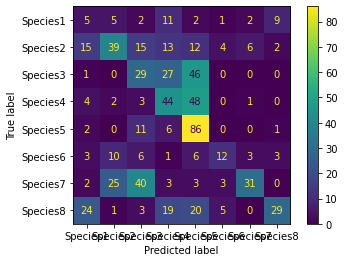

              precision    recall  f1-score   support

    Species1       0.09      0.14      0.11        37
    Species2       0.48      0.37      0.41       106
    Species3       0.27      0.28      0.27       103
    Species4       0.35      0.43      0.39       102
    Species5       0.39      0.81      0.52       106
    Species6       0.48      0.27      0.35        44
    Species7       0.72      0.29      0.41       107
    Species8       0.66      0.29      0.40       101

    accuracy                           0.39       706
   macro avg       0.43      0.36      0.36       706
weighted avg       0.46      0.39      0.38       706



In [ ]:
testModel(valid_gen, axn)

#ANN visualization

In [20]:
!pip install visualkeras
!pip install ann_visualizer
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
vgg16 = tfk.models.load_model("savedModels/BestModel_1") 

In [53]:
xception = tfk.models.load_model("savedModels/CNN_XCeption_3_FineTuning")

In [39]:
ensamble = tfk.models.load_model('savedModels/EnsambleModel_2')

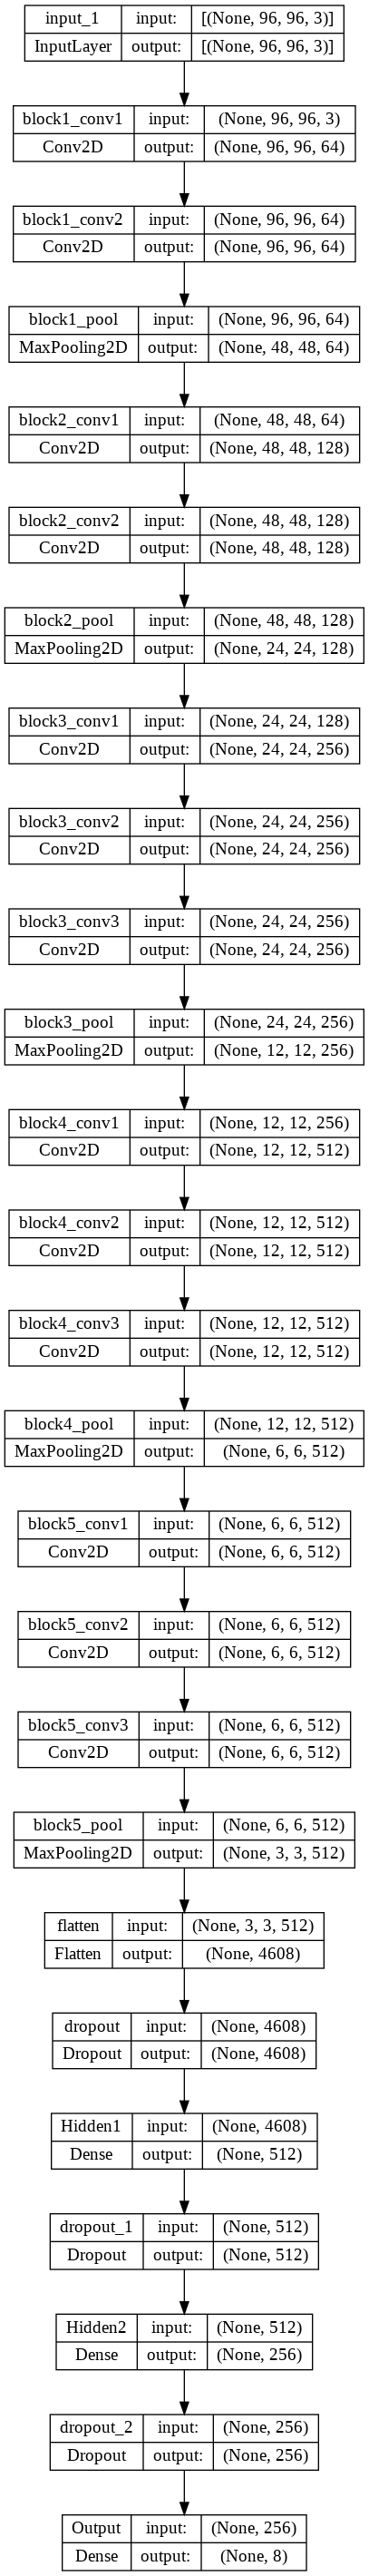

In [37]:
from keras.utils.vis_utils import plot_model
plot_model(vgg16, show_shapes=True, show_layer_names=True)

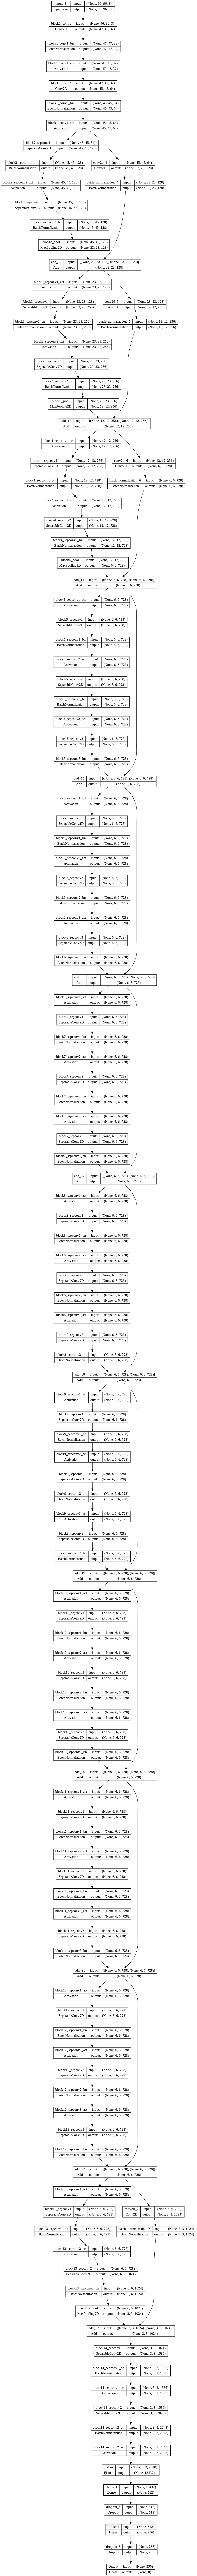

In [51]:
plot_model(xception, show_shapes=True, show_layer_names=True)

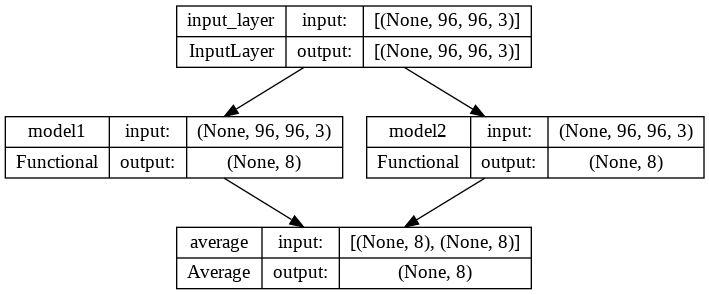

In [40]:
plot_model(ensamble, show_shapes=True, show_layer_names=True)

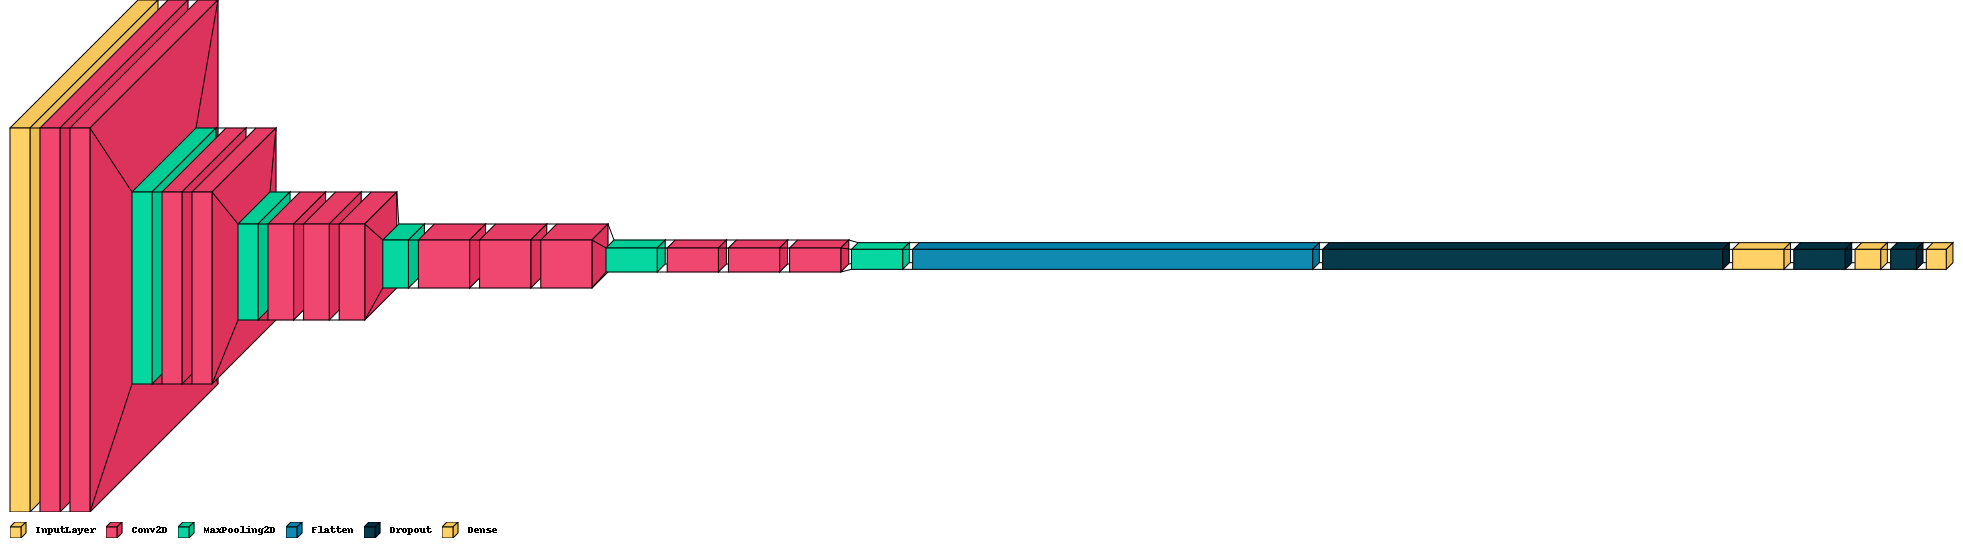

In [42]:
import visualkeras
visualkeras.layered_view(vgg16, legend=True)

xCeption wit ALL layers

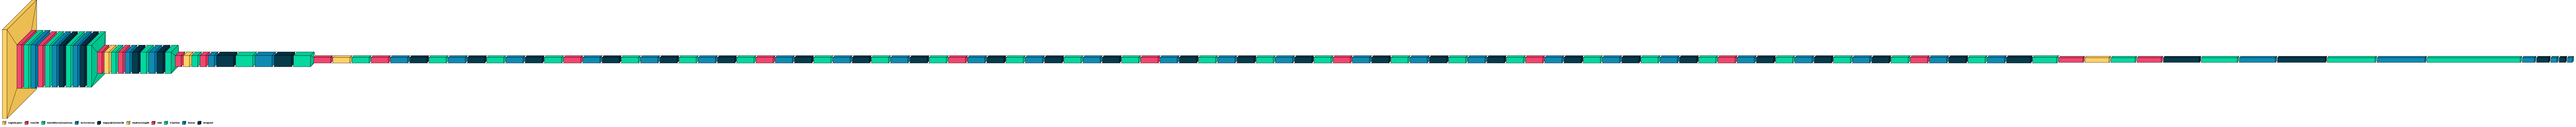

In [52]:
visualkeras.layered_view(xception, legend = True)

xCeption as a unique box

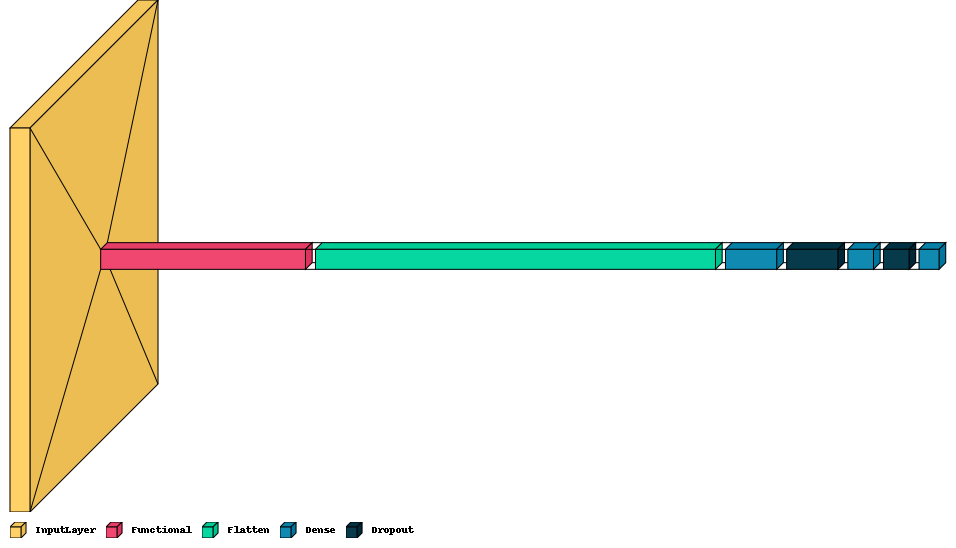

In [54]:
visualkeras.layered_view(xception, legend = True)

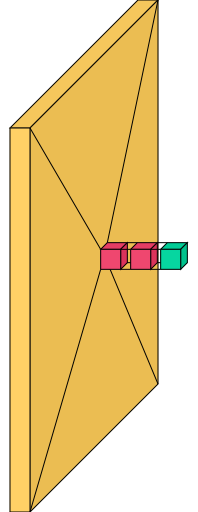

In [41]:
visualkeras.layered_view(ensamble)